<a href="https://colab.research.google.com/github/Gongsoo/Python3/blob/main/Mnist_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
from torchvision.utils import save_image
import torchvision.datasets as dsets
import torchvision.transforms as transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [49]:
standardizator = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,),std=(0.5,))])#무엇?

train_data = dsets.MNIST(root='data/',train=True,transform=standardizator, download=True)
test_data = dsets.MNIST(root='data/',train=False,transform=standardizator, download=True)

batch_size = 200
train_data_loader = torch.utils.data.DataLoader(train_data,batch_size, shuffle = True)
test_data_loader = torch.utils.data.DataLoader(test_data,batch_size, shuffle = True)



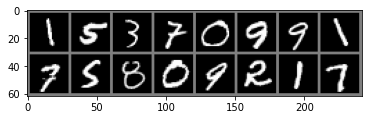

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img) :
  img = (img+1)/2
  img = img.squeeze()
  np_img = img.numpy()
  plt.imshow(np_img,cmap='gray')
  plt.show()

def imshow_grid(img) :
  img = utils.make_grid(img.cpu().detach())
  img = (img+1)/2
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

'''for i, img in enumerate(train_data_loader) :
  print(i,len(img))
  print(img[0].size())'''
ex_x,ex_y=next(iter(train_data_loader))
imshow_grid(ex_x[:16,:,:])

In [51]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [52]:
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200

In [53]:
# Discriminator

D = nn.Sequential(
    nn.Linear(image_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

G = nn.Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

D = D.to(device)
G = G.to(device)

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(),lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(),lr=0.0002)

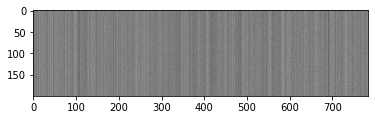

In [54]:
def sample_z(batch_size = 1, d_noise=64) :
  return torch.randn(batch_size, d_noise, device = device)

z = sample_z()
'''
img_fake = G(z).view(-1,28,28)

imshow(img_fake.squeeze().cpu().detach())
'''
z = sample_z(batch_size)
img_fake = G(z)
imshow_grid(img_fake)
                     

In [61]:
total_step = len(train_data_loader)

for epoch in range(num_epochs) :
  for i, (images,_) in enumerate(train_data_loader) :
    images = images.reshape(batch_size,-1).to(device)

    real_labels = torch.ones(batch_size,1).to(device)
    fake_labels = torch.zeros(batch_size,1).to(device)

    #train D
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    #Backprop
    d_loss = d_loss_real + d_loss_fake
    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    #train G
    z = torch.randn(batch_size,latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)

    g_loss = criterion(outputs,real_labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()

  print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
  if (epoch+1) == 1 :
    images = images.reshape(images.size(0),1,28,28)
    save_image(denorm(images),os.path.join('/content/drive/MyDrive/jj','real_images.png'))
  fake_images = fake_images.reshape(fake_images.size(0),1,28,28)
  save_image(denorm(fake_images), os.path.join('/content/drive/MyDrive/jj','fake_images-{}.png'.format(epoch+1)))



Epoch [0/200], Step [300/300], d_loss: 0.4357, g_loss: 3.5740, D(x): 0.88, D(G(z)): 0.16
Epoch [1/200], Step [300/300], d_loss: 0.5711, g_loss: 2.7377, D(x): 0.81, D(G(z)): 0.16
Epoch [2/200], Step [300/300], d_loss: 0.6453, g_loss: 2.6786, D(x): 0.80, D(G(z)): 0.16
Epoch [3/200], Step [300/300], d_loss: 0.3917, g_loss: 3.6683, D(x): 0.85, D(G(z)): 0.09
Epoch [4/200], Step [300/300], d_loss: 0.4752, g_loss: 2.8866, D(x): 0.87, D(G(z)): 0.17
Epoch [5/200], Step [300/300], d_loss: 0.6369, g_loss: 2.2832, D(x): 0.82, D(G(z)): 0.20
Epoch [6/200], Step [300/300], d_loss: 0.4266, g_loss: 3.3922, D(x): 0.85, D(G(z)): 0.13
Epoch [7/200], Step [300/300], d_loss: 0.4679, g_loss: 3.5084, D(x): 0.85, D(G(z)): 0.13
Epoch [8/200], Step [300/300], d_loss: 0.5919, g_loss: 2.9879, D(x): 0.89, D(G(z)): 0.23
Epoch [9/200], Step [300/300], d_loss: 0.4449, g_loss: 3.5520, D(x): 0.85, D(G(z)): 0.16
Epoch [10/200], Step [300/300], d_loss: 0.4412, g_loss: 3.0053, D(x): 0.86, D(G(z)): 0.15
Epoch [11/200], Step